# Inicializace

In [1]:
from tensorflow import keras
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import h5py

from __future__ import print_function

import tensorflow as tf
import os
import numpy as np
from sklearn.utils import class_weight
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D,Conv3DTranspose, ZeroPadding3D, Activation, Input, Dropout
from keras.layers import MaxPooling3D, UpSampling3D, concatenate
from keras.models import Model
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from zipfile import ZipFile
import h5py
import json
from typing import Tuple
#import skimage.transform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Conv3DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose

2023-08-06 00:14:50.753268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
    return weighted_binary_crossentropy


def uloz(filename, model):
    model.save_weights('weights__' + filename + '.h5')
    with open('history__' + filename + '.json', 'w') as f:
        json.dump(model.history.history, f)
        
        
def nacti_model(filename,rozmer,version,adresar):
    f = open(os.getcwd() +  '/history__' + filename + '.json') 
    data = json.load(f)
    f.close()
    print('Delka historie: ' + str(len(data['loss'])))
    
    model = get_unet(version=version, shape=(rozmer,rozmer,rozmer), class_weights=None)
    if(adresar == 'seg'):
        class_weights = [0.5,30]
        X_train = X_train_seg[0:1]
        Y_train = Y_train_seg[0:1]       
    elif(adresar == 'bif'):
        class_weights = [0.5,130]
        X_train = X_train_bif[0:1]
        Y_train = Y_train_bif[0:1]        
    elif(adresar == 'cen'):
        class_weights = [0.5,130]
        X_train = X_train_cen[0:1]
        Y_train = Y_train_cen[0:1]
    
    model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=[dice_coef, "accuracy"])
    model.load_weights(os.getcwd() +  '/weights__' + filename + '.h5')    
    model.fit(X_train, Y_train, epochs=1)
    model.history.history = data
    return model


def get_unet(version=1, shape=(50,50,50), class_weights=None):
    K.set_image_data_format('channels_last')
    inputs = Input((shape[0], shape[1], shape[2], 1))
    
    if(version == 1):
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)
        #bottleneck
        conv3 = Conv3D(512, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv3D(512, 3, activation='relu', padding='same')(conv3)
        drop3 = Dropout(0.5)(conv3)

        up4 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv4 = Conv3D(64, 3, activation='relu', padding='same')(up4)
        conv4 = Conv3D(64, 3, activation='relu', padding='same')(conv4)

        up5 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv5 = Conv3D(32, 3, activation='relu', padding='same')(up5)
        conv5 = Conv3D(32, 3, activation='relu', padding='same')(conv5)

        conv6 = Conv3D(1, 1, activation='sigmoid')(conv5)
        model = Model(inputs=[inputs], outputs=[conv6])
    
    if(version == 2):
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)

        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling3D(pool_size=(2, 2 ,2))(conv3)
        drop3 = Dropout(0.5)(conv3)

        conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
        drop4 = Dropout(0.5)(conv4)
        #bottleneck
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        up6 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
        conv6 = Conv3D(256, 3, activation = 'relu', padding = 'same')(up6)
        conv6 = Conv3D(256, 3, activation = 'relu', padding = 'same')(conv6)

        up7 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
        conv7 = Conv3D(128, 3, activation='relu', padding='same')(up7)
        conv7 = Conv3D(128, 3, activation='relu', padding='same')(conv7)

        up8 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv8 = Conv3D(64, 3, activation='relu', padding='same')(up8)
        conv8 = Conv3D(64, 3, activation='relu', padding='same')(conv8)

        up9 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv9 = Conv3D(32, 3, activation='relu', padding='same')(up9)
        conv9 = Conv3D(32, 3, activation='relu', padding='same')(conv9)

        conv10 = Conv3D(1, 1, activation='sigmoid')(conv9)
        model = Model(inputs=[inputs], outputs=[conv10])
        
    if(version == 3):
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
        drop2 = Dropout(0.5)(conv2)

        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling3D(pool_size=(2, 2 ,2))(conv3)
        drop3 = Dropout(0.5)(conv3)

        conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
        drop4 = Dropout(0.5)(conv4)
    
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv3D(512, 3, activation='relu', padding='same')(conv5)
        pool5 = MaxPooling3D(pool_size=(2, 2, 2))(conv5)
        drop5 = Dropout(0.5)(conv5)
    
        conv6 = Conv3D(1024, 3, activation='relu', padding='same')(pool5)
        conv6 = Conv3D(1024, 3, activation='relu', padding='same')(conv6)
        pool6 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)
        drop6 = Dropout(0.5)(conv6)
        #bottleneck
        conv7 = Conv3D(1024, 3, activation='relu', padding='same')(pool6)
        conv7 = Conv3D(1024, 3, activation='relu', padding='same')(conv7)
        drop7 = Dropout(0.5)(conv7)
        
        up8 = Conv3D(2048, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop7))
        conv8 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
        conv8 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop6))
        conv9 = Conv3D(512, 3, activation='relu', padding='same')(up9)
        conv9 = Conv3D(512, 3, activation='relu', padding='same')(conv9)
    
        up10 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
        conv10 = Conv3D(256, 3, activation='relu', padding='same')(up10)
        conv10 = Conv3D(256, 3, activation='relu', padding='same')(conv10)
    
        up11 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
        conv11 = Conv3D(128, 3, activation='relu', padding='same')(up11)
        conv11 = Conv3D(128, 3, activation='relu', padding='same')(conv11)

        up12 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop3))
        conv12 = Conv3D(64, 3, activation='relu', padding='same')(up12)
        conv12 = Conv3D(64, 3, activation='relu', padding='same')(conv12)

        up13 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop2))
        conv13 = Conv3D(32, 3, activation='relu', padding='same')(up13)
        conv13 = Conv3D(32, 3, activation='relu', padding='same')(conv13)

        conv14 = Conv3D(1, 1, activation='sigmoid')(conv13)
        model = Model(inputs=[inputs], outputs=[conv14])       
        
    return model

def trenuj(model, epoch):
    history = model.history
    h = model.fit(
        train_generator,
        epochs= epoch,
        steps_per_epoch=X_train.shape[0] // batch_size,
        validation_data=val_generator,
        validation_steps=X_val.shape[0] // batch_size,
        validation_freq=1
    )

    for i in range(len(h.history['loss'])):
        history.history['loss'].append(h.history['loss'][i])        
        history.history['val_loss'].append(h.history['val_loss'][i])
        history.history['dice_coef'].append(h.history['dice_coef'][i])
        history.history['val_dice_coef'].append(h.history['val_dice_coef'][i])
        history.history['accuracy'].append(h.history['accuracy'][i])
        history.history['val_accuracy'].append(h.history['val_accuracy'][i])
        
    model.history = history

In [3]:
def nacti(file, index):
    f = h5py.File(file, 'r')
    raw = f["raw"][index,:,:,:,0]
    seg = f["seg"][index,:,:,:,0]
    bif = f["bif"][index,:,:,:,0]
    centerline = f["centerline"][index,:,:,:,0]
    f.close
    return raw,seg,bif,centerline

def vykresli_data(data):    
    # plot with various axes scales
    plt.figure()

    # raw
    plt.subplot(4,4,1)
    plt.imshow(data[0][:,:,220])
    plt.title('raw')
    plt.grid(False)

    # seg
    plt.subplot(4,4,2)
    plt.imshow(data[1][:,:,220])
    plt.title('seg')
    plt.grid(False)

    # bif
    plt.subplot(4,4,3)
    plt.imshow(data[2][:,:,220])
    plt.title('bif')
    plt.grid(False)

    # centerline
    plt.subplot(4,4,4)
    plt.imshow(data[3][:,:,220])
    plt.title('centerline')
    plt.grid(False)
    
    # Adjust the subplot layout, because the logit one may take more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    plt.gcf().set_size_inches(20, 20)
    plt.subplots_adjust(top=0.7, bottom=0.1, left=0.10, right=0.95, hspace=0.1, wspace=0.35)
    plt.show()
    

def data(dir_root,rozmer,index,pocet,adresar_index):
    d = nacti(dir_root,index)
    shape = d[0].shape
    delka = int(shape[0]/rozmer)
    sirka = int(shape[1]/rozmer)
    hloubka = int(shape[2]/rozmer)

    X = []
    Y = []

    for p in range(pocet):
        d = nacti(dir_root,index + p)
        predlohaX = np.zeros((rozmer, rozmer, rozmer, 1))
        predlohaY = np.zeros((rozmer, rozmer, rozmer, 1))
        for o in range(delka):
            for j in range(sirka):
                for k in range(hloubka):
                    predlohaX[:,:,:,0] = d[0][(o%delka)*rozmer:(o%delka+1)*rozmer,(j%sirka)*rozmer:(j%sirka+1)*rozmer,(k%hloubka)*rozmer:(k%hloubka+1)*rozmer] #raw 
                    predlohaY[:,:,:,0] = d[adresar_index][(o%delka)*rozmer:(o%delka+1)*rozmer,(j%sirka)*rozmer:(j%sirka+1)*rozmer,(k%hloubka)*rozmer:(k%hloubka+1)*rozmer] #seg
                    X.append(predlohaX) #raw                    
                    Y.append(predlohaY) #seg

    Y = np.array(Y).astype('float64')
    X = np.array(X).astype('int16')    
    return X,Y

def img_generator(img_dir, mask_dir, batch_size):
    while True:
        ix = np.random.choice(np.arange(img_dir.shape[0]), batch_size)
        imgs = []
        labels = []

        for i in ix:
            imgs.append(img_dir[i])
            labels.append(mask_dir[i])

        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels
    
def vykresli(model):
    plt.figure()
    plt.subplot(4,4,1)
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['dice_coef'])
    plt.plot(model.history.history['accuracy'])
    plt.title('Průběh trénování')
    plt.ylabel('Metrika')
    plt.xlabel('Epochy')
    plt.legend(['Loss', 'Dice_coeficient', 'Accuracy'], loc='lower right')
    plt.grid(False)
    
    plt.subplot(4,4,2)
    plt.plot(model.history.history['val_loss']) 
    plt.plot(model.history.history['val_dice_coef'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Průběh trénování')
    plt.ylabel('Metrika')
    plt.xlabel('Epochy')
    plt.legend(['val_Loss', 'val_Dice_coeficient', 'val_Accuracy'], loc='lower right')
    plt.grid(False)
    
    # Adjust the subplot layout, because the logit one may take more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    plt.gcf().set_size_inches(20, 20)
    plt.subplots_adjust(top=0.7, bottom=0.1, left=0.10, right=0.95, hspace=0.1, wspace=0.35)
    plt.show()

# Data

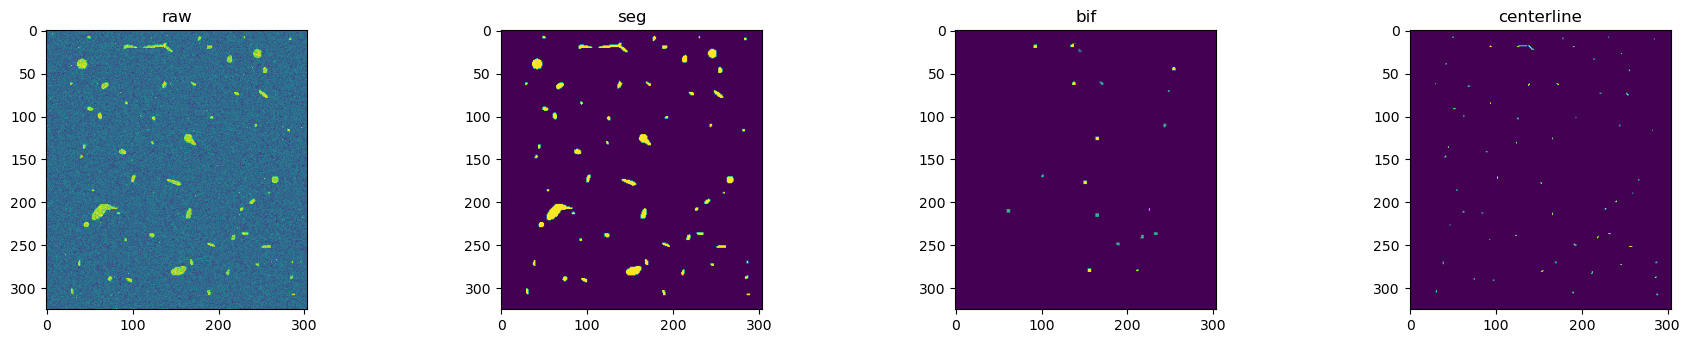


Train:
(432, 50, 50, 50, 1) int16 1 255
(432, 50, 50, 50, 1) float64 0.0 1.0

Validation:
(432, 50, 50, 50, 1) int16 3 255
(432, 50, 50, 50, 1) float64 0.0 4.0

Test:
(432, 50, 50, 50, 1) int16 12 255
(432, 50, 50, 50, 1) float64 0.0 1.0


In [5]:
dir_root_train =  os.getcwd() + '/dataset_train_small.h5'
dir_root_val =  os.getcwd() + '/dataset_validation_small.h5'
dir_root_test =  os.getcwd() + '/dataset_test_small.h5'

rozmer = 50
adresare = ["raw","seg","bif","centerline"]
adresar_index = 1  

pocet_train_souboru = 1
pocet_val_souboru = 1
pocet_test_souboru = 1
###############################################

vykresli_data(nacti(dir_root_train, 1))

X_train_seg, Y_train_seg = data(dir_root_train,rozmer, 0, pocet_train_souboru, 1)
X_val_seg, Y_val_seg = data(dir_root_val,rozmer, 0, pocet_val_souboru, 1)
X_test_seg, Y_test_seg = data(dir_root_test,rozmer, 0, pocet_test_souboru, 1)

X_train_bif, Y_train_bif = data(dir_root_train,rozmer, 0, pocet_train_souboru, 2)
X_val_bif, Y_val_bif = data(dir_root_val,rozmer, 0, pocet_val_souboru, 2)
X_test_bif, Y_test_bif = data(dir_root_test,rozmer, 0, pocet_test_souboru, 2) 

X_train_cen, Y_train_cen = data(dir_root_train,rozmer, 0, pocet_train_souboru, 3)
X_val_cen, Y_val_cen = data(dir_root_val,rozmer, 0, pocet_val_souboru, 3)
X_test_cen, Y_test_cen = data(dir_root_test,rozmer, 0, pocet_test_souboru, 3) 

print('\nTrain:')
print(X_train_seg.shape, X_train_seg.dtype, np.min(X_train_seg), np.max(X_train_seg))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(Y_train_seg.shape, Y_train_seg.dtype, np.min(Y_train_seg), np.max(Y_train_seg)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print('\nValidation:')
print(X_val_bif.shape, X_val_bif.dtype, np.min(X_val_bif), np.max(X_val_bif))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(Y_val_bif.shape, Y_val_bif.dtype, np.min(Y_val_bif), np.max(Y_val_bif)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print('\nTest:')
print(X_test_cen.shape, X_test_cen.dtype, np.min(X_test_cen), np.max(X_test_cen))  # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)
print(Y_test_cen.shape, Y_test_cen.dtype, np.min(Y_test_cen), np.max(Y_test_cen)) # (32, 256, 256, 3) = (batch_size, num_rows, num_cols, num_channels)


In [10]:
batch_size = 10
velikost_train = 10
velikost_val = 10
velikost_test = 100
#######################################################
train_generator_seg = img_generator(X_train_seg[0:velikost_train], Y_train_seg[0:velikost_train] , batch_size)
val_generator_seg = img_generator(X_val_seg[0:velikost_val], Y_val_seg[0:velikost_val], batch_size)
test_generator_seg = img_generator(X_test_seg[0:velikost_test], Y_test_seg[0:velikost_test], batch_size)

train_generator_bif = img_generator(X_train_bif[0:velikost_train], Y_train_bif[0:velikost_train] , batch_size)
val_generator_bif = img_generator(X_val_bif[0:velikost_val], Y_val_bif[0:velikost_val], batch_size)
test_generator_bif = img_generator(X_test_bif[0:velikost_test], Y_test_bif[0:velikost_test], batch_size)

train_generator_cen = img_generator(X_train_cen[0:velikost_train], Y_train_cen[0:velikost_train] , batch_size)
val_generator_cen = img_generator(X_val_cen[0:velikost_val], Y_val_cen[0:velikost_val], batch_size)
test_generator_cen = img_generator(X_test_cen[0:velikost_test], Y_test_cen[0:velikost_test], batch_size)

# Načti uložený model

In [12]:
version_of_unet = 1   #1 , 2, 3

model_seg_10 = nacti_model('seg1_10dat_200epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_50 = nacti_model('seg1_50dat_200epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_100 = nacti_model('seg1_100dat_200epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_150 = nacti_model('seg1_150dat_200epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_200 = nacti_model('seg1_200dat_200epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_300 = nacti_model('seg1_300dat_100epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_400 = nacti_model('seg1_400dat_100epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_500 = nacti_model('seg1_500dat_50epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')
model_seg_600 = nacti_model('seg1_600dat_50epoch',rozmer=rozmer,version=version_of_unet,adresar='seg')

Delka historie: 201
1/1 [==============================] - 2s 2s/step - loss: 0.0214 - dice_coef: 0.7544 - accuracy: 0.9896
Delka historie: 201
1/1 [==============================] - 2s 2s/step - loss: 0.0044 - dice_coef: 0.9432 - accuracy: 0.9981
Delka historie: 201
1/1 [==============================] - 2s 2s/step - loss: 0.0047 - dice_coef: 0.9361 - accuracy: 0.9978
Delka historie: 201
1/1 [==============================] - 2s 2s/step - loss: 7.7366e-04 - dice_coef: 0.9838 - accuracy: 0.9995
Delka historie: 201
1/1 [==============================] - 2s 2s/step - loss: 3.5204e-04 - dice_coef: 0.9944 - accuracy: 0.9998
Delka historie: 101
1/1 [==============================] - 2s 2s/step - loss: 9.7318e-04 - dice_coef: 0.9813 - accuracy: 0.9994
Delka historie: 101
1/1 [==============================] - 2s 2s/step - loss: 0.0011 - dice_coef: 0.9789 - accuracy: 0.9994
Delka historie: 23
1/1 [==============================] - 2s 2s/step - loss: 8.4448e-04 - dice_coef: 0.9862 - accuracy: 

# Vyhodnoceni

In [21]:
x, y = next(train_generator_seg)
result_seg_10 = model_seg_10.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_50 = model_seg_50.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_100 = model_seg_100.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_150 = model_seg_150.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_200 = model_seg_200.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_300 = model_seg_300.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_400 = model_seg_400.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_500 = model_seg_500.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)
result_seg_600 = model_seg_600.evaluate(x,y,batch_size=batch_size,steps=velikost_test//batch_size)

predict_seg_10 = model_seg_10.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_50 = model_seg_50.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_100 = model_seg_100.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_150 = model_seg_150.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_200 = model_seg_200.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_300 = model_seg_300.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_400 = model_seg_400.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_500 = model_seg_500.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)
predict_seg_600 = model_seg_600.predict(x,batch_size=batch_size,steps=velikost_test//batch_size)

10/10 [==============================] - 5s 1ms/step


In [22]:
print('Výsledek testování: ')
print('\tLoss: ' + str(result_seg_10[0]))
print('\tDice_coef: ' + str(result_seg_10[1]))
print('\tAccuracy: ' + str(result_seg_10[2]) + '\n')
print('Tvar predikce: ' + str(predict_seg_10.shape))

Výsledek testování: 
	Loss: 0.11196782439947128
	Dice_coef: 0.5878774523735046
	Accuracy: 0.9776080250740051

Tvar predikce: (10, 50, 50, 50, 1)


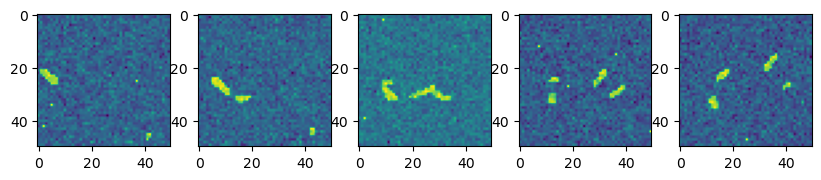

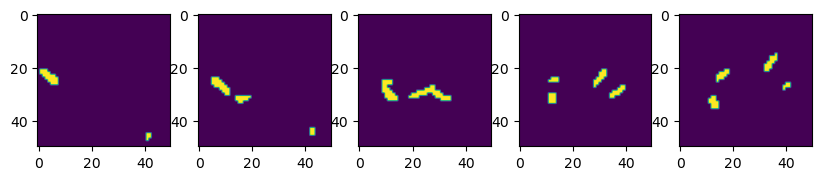

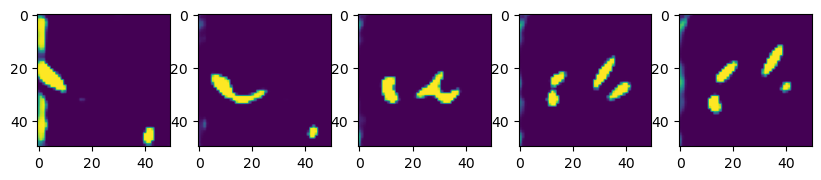

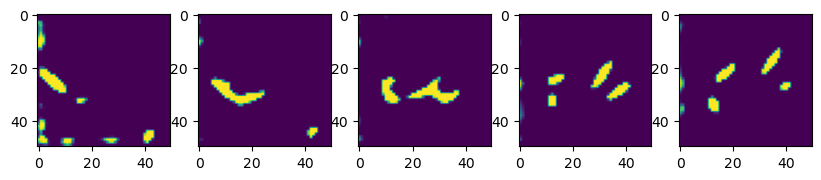

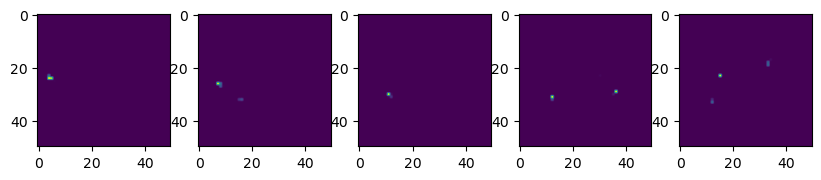

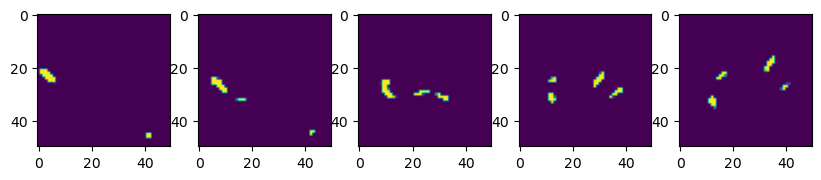

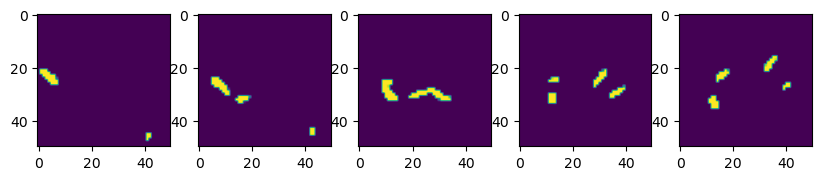

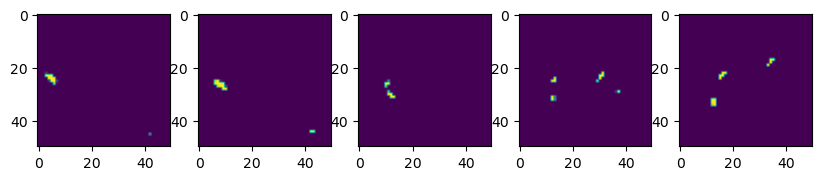

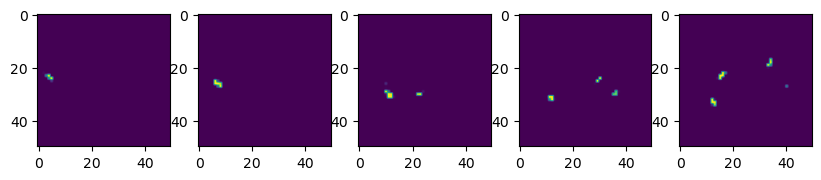

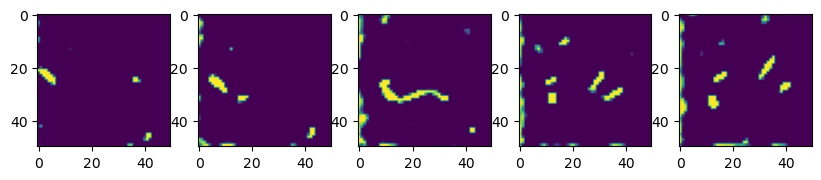

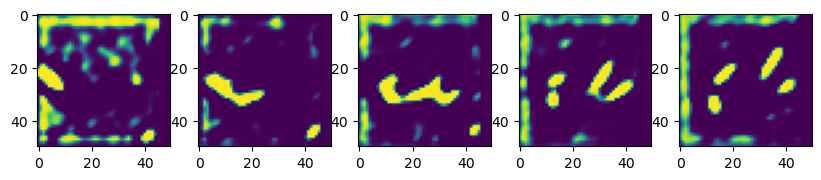

In [31]:
soubor = 0
vrstva = 40

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(y[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_10[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_50[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_100[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_150[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_200[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_300[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_400[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_500[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(predict_seg_600[0,:,:,2*i+1,0])
plt.gcf().set_size_inches(10, 10)
plt.show()

# Vytvoř nový model

In [14]:
version_of_unet = 1   #1 , 2, 3
#####################################################################################
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train.flatten()), y=Y_train.flatten()) #class_weights = [0.5, 30]
print('class_weights: ' + str(class_weights))
print('X_train:' + str(X_train.shape[0]), 'batch_size:' + str(batch_size), 'steps_per_epoch:' + str(X_train.shape[0] // batch_size))
print('X_valid:' + str(X_train.shape[0]), 'batch_size:' + str(batch_size), 'steps_per_epoch:' + str(X_train.shape[0] // batch_size))
print()

model = get_unet(version=1, shape=(rozmer,rozmer,rozmer))
model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), metrics=[dice_coef, "accuracy"])
model.fit(X_train, Y_train, epochs=1,validation_data=(X_val, Y_val),validation_freq=1)

class_weights: [ 0.50889964 28.59103385]
X_train:10 batch_size:10 steps_per_epoch:1
X_valid:10 batch_size:10 steps_per_epoch:1

1/1 [==============================] - 15s 15s/step - loss: 3.7116 - dice_coef: 0.0346 - accuracy: 0.0272 - val_loss: 1.7338 - val_dice_coef: 0.0062 - val_accuracy: 0.9890


# Trenování

In [ ]:
epochy = 50
kolikrat = 4
#####################################
for i in range(kolikrat):
    print('\nTrenován:' + str(i+1))
    filename = str(adresare[adresar_index]) + str(version_of_unet) + '_' + str(X_train.shape[0]) + 'dat_' + str(epochy*(i+1)) + 'epoch'    
    
    trenuj(model, epochy)
    uloz(filename, model)

In [ ]:
vykresli(model)